# 0.0 IMPORTS

## 0.1 Libraries

In [2]:
#!pip install pyarrow

In [3]:
import os
import random
import bisect
import warnings

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
from matplotlib          import pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine        as c

from pandas_profiling        import ProfileReport

from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier

from skopt                   import forest_minimize

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix


# import sys
# sys.path.append('../')
# ## My Functions
# from modules.postgres import Postgres


from sqlalchemy import create_engine, inspect

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [4]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [5]:
jupyter_settings()

### 0.2.2 Functions

In [6]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m




def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))




def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]


################## Revisar
def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                       'Precision': precision, 
                       'Recall': recall,
                       'F1 Score': f1,
                       'Kappa': kappa,
                       'Balanced Accuracy': balanced_accuracy,
                       'Average Precision Score': ap,
                       'ROC AUC': roc_auc}, index=[0])
    

################## Revisar    
def cross_validation(X_train, y_train, model_name, model, num_folds=5, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
            
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

### 0.3.1 Check Schemas & Tables

In [74]:
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
usenamer = os.environ.get('POSTGRES_CDS_USERNAME')
password = os.environ.get('POSTGRES_CDS_PASSWORD')
port = 5432
database = 'comunidadedsdb'

engine = create_engine(f"postgresql://{usenamer}:{password}@{host}:{port}/{database}")

inspector = inspect(engine)

# get schemas
schemas = inspector.get_schema_names()

for schema in schemas:
    if (schema != 'information_schema') & (schema != 'public'):
        # list of tables in each schema
        print('schema: {}'.format(schema))
        tables = inspector.get_table_names(schema=schema)
        for table in tables:
            print('table: {}'.format(table))

schema: pa004
table: users
table: vehicle
table: insurance


### 0.302 Query Data

In [75]:
with open('../02-Query/raw_data.sql', mode='r', encoding='utf-8-sig') as query:
    query_raw_data = query.read()


with engine.connect() as conn:
    df_raw = pd.read_sql(query_raw_data, conn)

In [9]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


### 0.3.5 Saving Test Data

In [10]:
# Apply stratified sampling in order to keep target variable proportion in the train and test datasets
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(df_raw, df_raw['response']):
#     train_dataset = df_raw.loc[train_index].reset_index(drop=True)
#     test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
# train_dataset.to_feather('../00-Data/training_data.feather')
# test_dataset.to_feather('../00-Data/test_data.feather')

### 0.3.6 Read Training Dataset

In [11]:
# df_train = pd.read_feather('../00-Data/training_data.feather')
df_train = df_raw.copy()

# 1.0 DATA DESCRIPTION

In [12]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 1.1 Data Dimensions

In [13]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Type

In [14]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [15]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## ~~1.4 Change Data type~~

## 1.5 Check Balanced Data

In [16]:
df01['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [17]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [18]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.822584,36.0,21.0,22.0,25.0,49.0,62.0,69.0,15.511591,0.399551,0.672539,-0.565655
1,region_code,0.0,52.0,52.0,28.0,26.388807,28.0,5.0,8.0,15.0,35.0,46.0,47.0,13.229871,0.501344,-0.115266,-0.867857
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.034295,133.0,26.0,26.0,29.0,152.0,156.0,160.0,54.203924,0.483815,-0.900008,-0.970810
3,driving_license,0.0,1.0,1.0,1.0,0.997869,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.046109,0.046208,-21.595182,464.354302
4,previously_insured,0.0,1.0,1.0,0.0,0.458210,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.498251,1.087384,0.167747,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30564.389581,31669.0,2630.0,2630.0,24405.0,39400.0,48431.0,55176.0,17213.132474,0.563176,1.766087,34.004569
6,vintage,10.0,299.0,289.0,256.0,154.347397,154.0,24.0,38.0,82.0,227.0,270.0,285.0,83.671194,0.542097,0.003030,-1.200688
7,response,0.0,1.0,1.0,0.0,0.122563,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.327935,2.675639,2.301906,3.298788


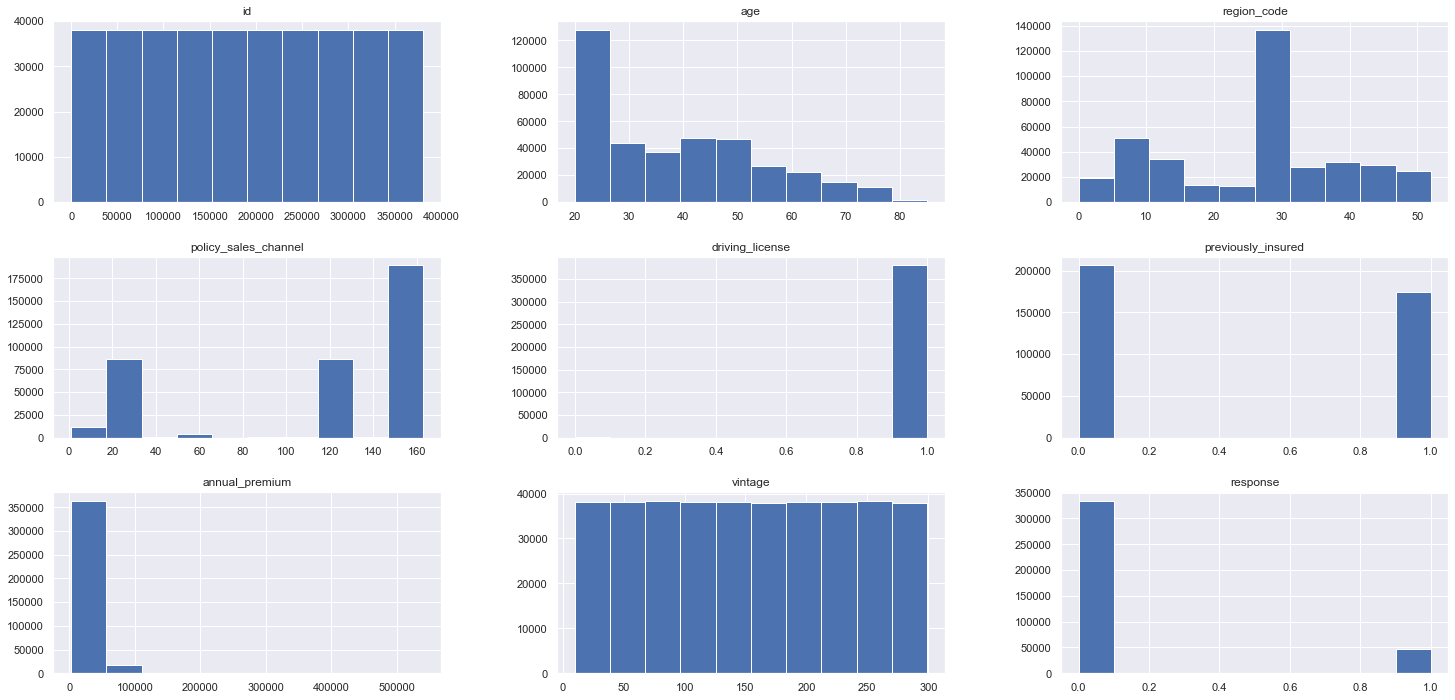

In [19]:
num_attributes.hist();

### 1.6.2 Categorical Attributes

In [20]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


### 1.6.3 Some Conclusions

Significant portion of customers (54,2%) don't have vehicle insurance
 
Most 95% of customer have license

All customers have less than one year of insurance and have a constant distribution 

Most customers are under 50 years old, 25% are up to 25 years old 

Most 95% of annual premmium cost until 55.292 and the range is 537535.0

Most customer are Male

Most customers vehicles age is less 2 years

Customers who have had the vehicle damaged in the past are evenly distributed to customers who have not had the vehicle damaged

Most 75% of customers don't have interest to buy a vehicle insurance

# 2.0 Feature Engineering

In [21]:
df02 = df01.copy()

In [22]:
# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)

# vehicle demage versus license
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)
df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


# vehicle_damage_vehicle_age
df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

# age / mean_age_by_region_code
region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
del region_code_mean_age


# age / mean_age_by_policy_sales_channel
policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# annual_premium / mean_annual_premium_by_region_code
region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# annual_premium / mean_annual_premium_by_policy_sales_channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

# age / vintage
df02['age_vintage'] = (df02['age']*365) / df02['vintage']

In [23]:
df02.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_stage,vehicle_damage_license,vehicle_damage_vehicle_age,mean_age_by_region_code,age_mean_age_by_region_code,mean_age_by_policy_sales_channel,age_mean_age_by_policy_sales_channel,mean_annual_premium_by_region_code,annual_premium_mean_annual_premium_by_region_code,mean_annual_premium_by_policy_sales_channel,annual_premium_mean_annual_premium_by_policy_sales_channel,age_vintage
0,7,Male,23,11.0,152.0,1,0,1,0,23367.0,249,0,Young,4,-1,34.374567,0.669099,26.214825,0.877366,27607.283146,0.846407,30889.192493,0.756478,33.714859
1,13,Female,41,15.0,14.0,1,1,0,1,31409.0,221,0,Adult,1,1,32.605876,1.257442,53.372990,0.768179,29624.520815,1.060237,33877.260450,0.927141,67.714932
2,18,Female,25,35.0,152.0,1,0,0,1,46622.0,299,0,Young,1,0,36.135264,0.691845,26.214825,0.953659,26832.931144,1.737492,30889.192493,1.509330,30.518395
3,31,Female,26,8.0,160.0,1,0,0,0,2630.0,136,0,Young,1,0,38.579567,0.673932,23.435006,1.109451,36467.985241,0.072118,25575.744938,0.102832,69.779412
4,39,Male,45,8.0,124.0,1,1,1,0,42297.0,264,0,Adult,4,-4,38.579567,1.166421,46.923589,0.959006,36467.985241,1.159839,31710.191162,1.333861,62.215909


# 3.0 Data Filtering

In [24]:
df03 = df02.copy()

## 3.1 Filtering Rows

## 3.2 Filtering Columns

In [25]:
cols_drop = ['id', # original data
             'mean_age_by_region_code', 'mean_age_by_policy_sales_channel', 'mean_annual_premium_by_region_code', 'mean_annual_premium_by_policy_sales_channel'] # auxiliary features
df03 = df03.drop(cols_drop, axis=1)

# 4.0 Balanced Dataset

In [26]:
df04 = df03.copy()

## 4.1 SMOTE + TOMEKLINK

In [27]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df04.select_dtypes(include=['int64', 'float64']).drop('response', axis=1).columns.tolist()

# Categorical
col_cat = df04.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Encoding
df04_dummy = pd.DataFrame(ohe.fit_transform(df04[col_cat]).toarray(), index=df04.index)

# join Numerical and Categorical
df04_1 = pd.concat([df04[col_num], df04_dummy], axis=1)

In [32]:
ratio_balanced = {
                    0: 334399,
                    1: 8*37368
                }

#ratio_balanced

{0: 334399, 1: 298944}

In [33]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df04_1, df04['response'])

In [34]:
# numerical data
df04_2 = X_smt[col_num]

# categorical data
df04_3 = X_smt.drop(col_num, axis=1)
df04_4 = pd.DataFrame(ohe.inverse_transform(df04_3), columns=col_cat, index=df04_3.index)

# join numerical and categorical
df04_5 = pd.concat([df04_2, df04_4], axis=1)
df04_5['response'] = y_smt

# 5.0 Exploratory Data Analysis (EDA)

In [35]:
df05_u = df04.copy()
df05 = df04_5.copy()

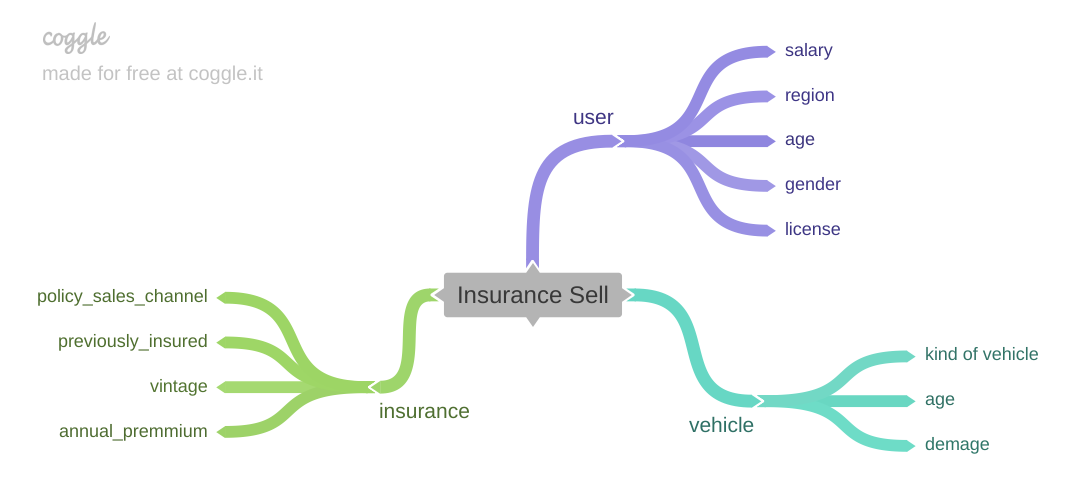

In [36]:
Image('../img/insurance_sell.png')

## 5.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

In [37]:
profile = ProfileReport(df05, title="Insurance Cross Sell", html={'style': {'full_width':True}}, minimal=True)

profile.to_file(output_file='insurance_cross_sell.html')

## 5.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

### 5.2.1 Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance more frequently
> - **H02** - Unlicensed customers do not purchase insurance
> - **H03** - Customers who already have vehicle insurance do not require the insurance offered
> - **H04** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H05** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H06** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H07** - Older customers in the portfolio acquire insurance
> - **H08** - Elderly customers do not purchase insurance
> - **H09** - Female customers already have vehicle insurance
> - **H10** - Customers with new and damaged vehicles purchase insurance
> - **H11** - Customers who have a plan that costs more than the average in the region acquire insurance
> - **H12** - Older customers in the portfolio are from the region 28
> - **H13** - Young customers came through channel 152
> - **H14** - Among the damaged cars, the largest portion belongs to young customers 

### 5.2.2 Final List of Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance
> - **H02** - Customers who already have vehicle insurance do not require the insurance offered
> - **H03** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H04** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance

#### **H01** - Customers over 30 years old purchase vehicle insurance more frequently
---
> **Conclusion: TRUE**
>> - Customers over 30 years old purchase vehicle insurance more frequently

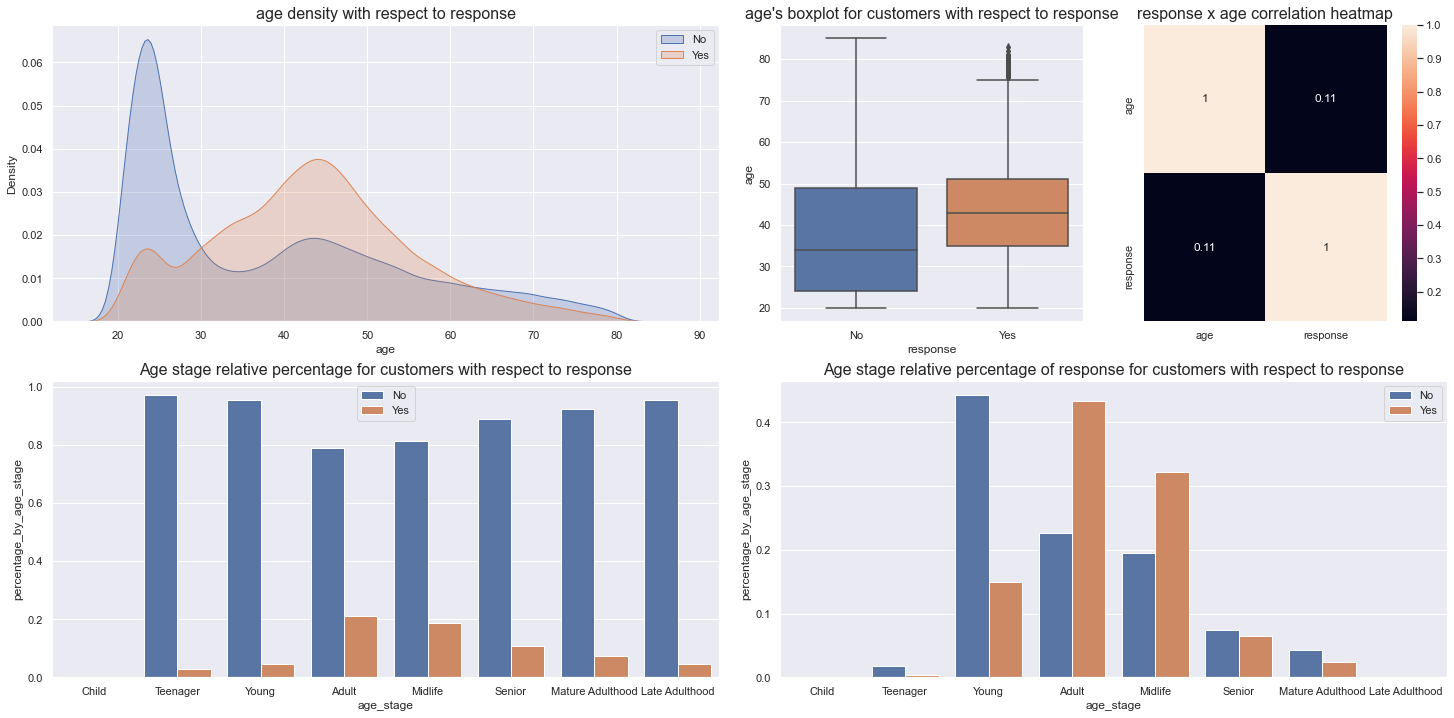

In [38]:
aux01 = df05_u[['age', 'age_stage', 'response']]


# Grid for ploting
grid = GridSpec(2, 4)

# response x age correlation heatmap
plt.subplot(grid[0,3:4])
sns.heatmap(aux01.corr(method='pearson'), annot=True).set_title("response x age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux01['response'] = aux01['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# age density with respect to response
plt.subplot(grid[0,:2])
sns.kdeplot(aux01[aux01['response'] == 'No']['age'], label='No', shade=True);
sns.kdeplot(aux01[aux01['response'] == 'Yes']['age'], label='Yes', shade=True);
plt.title("age density with respect to response", fontsize=16);
plt.legend();

# age's boxplot for customers with respect to response
plt.subplot(grid[0,2:3])
sns.boxplot(x="response", y="age", data=aux01).set_title("age's boxplot for customers with respect to response", fontsize=16);

# Age stage relative percentage for customers with respect to response
aux02 = pd.DataFrame()
age_stage_unique = aux01['age_stage'].unique().tolist()
for stage in age_stage_unique:
    aux02_0 = aux01[aux01['age_stage'] == stage][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
    aux02 = pd.concat([aux02, aux02_0])

## sort the x axis
age_stage_order = ['Child', 'Teenager', 'Young', 'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood']
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02);
plt.legend();
plt.title("Age stage relative percentage for customers with respect to response", fontsize=16);

# Age stage relative percentage of response for customers with respect to response
aux02_0 = aux01[aux01['response'] == 'No'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
aux02_1 = aux01[aux01['response'] == 'Yes'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})

aux02 = pd.concat([aux02_0, aux02_1], axis=0)

## sort the x axis
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,2:4])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02);
plt.legend();
plt.title("Age stage relative percentage of response for customers with respect to response", fontsize=16);

#### **H02** - Customers who already have vehicle insurance do not require the insurance offered
---
> **Conclusion: TRUE**
>> - Customers who already have vehicle insurance do not require the insurance offered

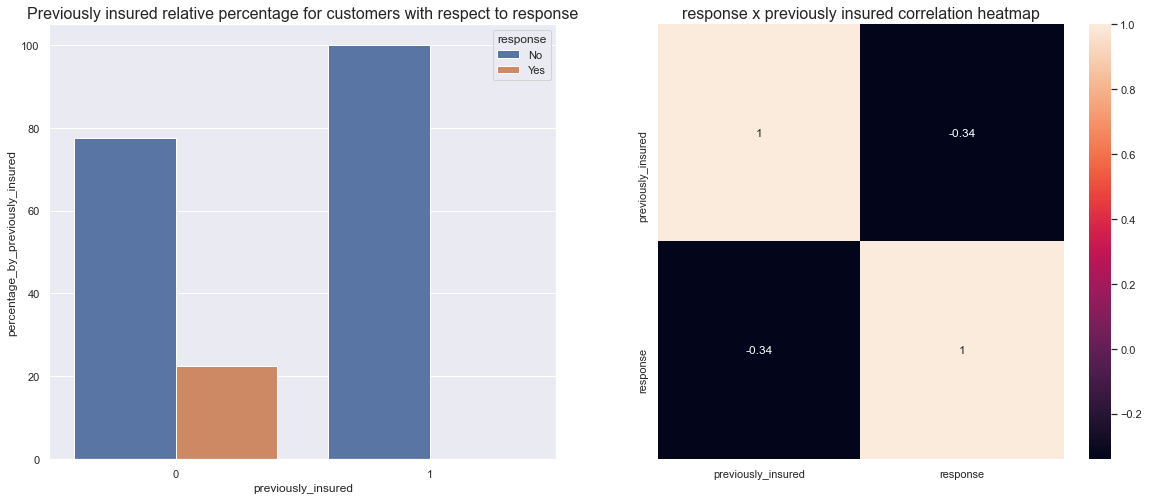

In [39]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
aux02 = df05_u[['previously_insured', 'response']]
# Previously insured relative percentage for customers with respect to response
aux02_0 = aux02[aux02['previously_insured'] == 1][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux02_1 = aux02[aux02['previously_insured'] == 0][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux03 = pd.concat([aux02_0, aux02_1], axis=0)

## Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
## transform to 100%
aux03['percentage_by_previously_insured'] = aux03['percentage_by_previously_insured'] * 100

## plot
sns.barplot(x='previously_insured', y='percentage_by_previously_insured', hue='response', data=aux03);
plt.title("Previously insured relative percentage for customers with respect to response", fontsize=16)

# response x previously insured correlation heatmap
plt.subplot(1,2,2)
sns.heatmap(aux02.corr(method='pearson'), annot=True).set_title("response x previously insured correlation heatmap", fontsize=16);

#### **H03** - Customers with vehicle that are less than 1 year old purchase insurance
---
> **Conclusion: FALSE**
>> - Customers with vehicle that are less than 1 year old do not purchase insurance

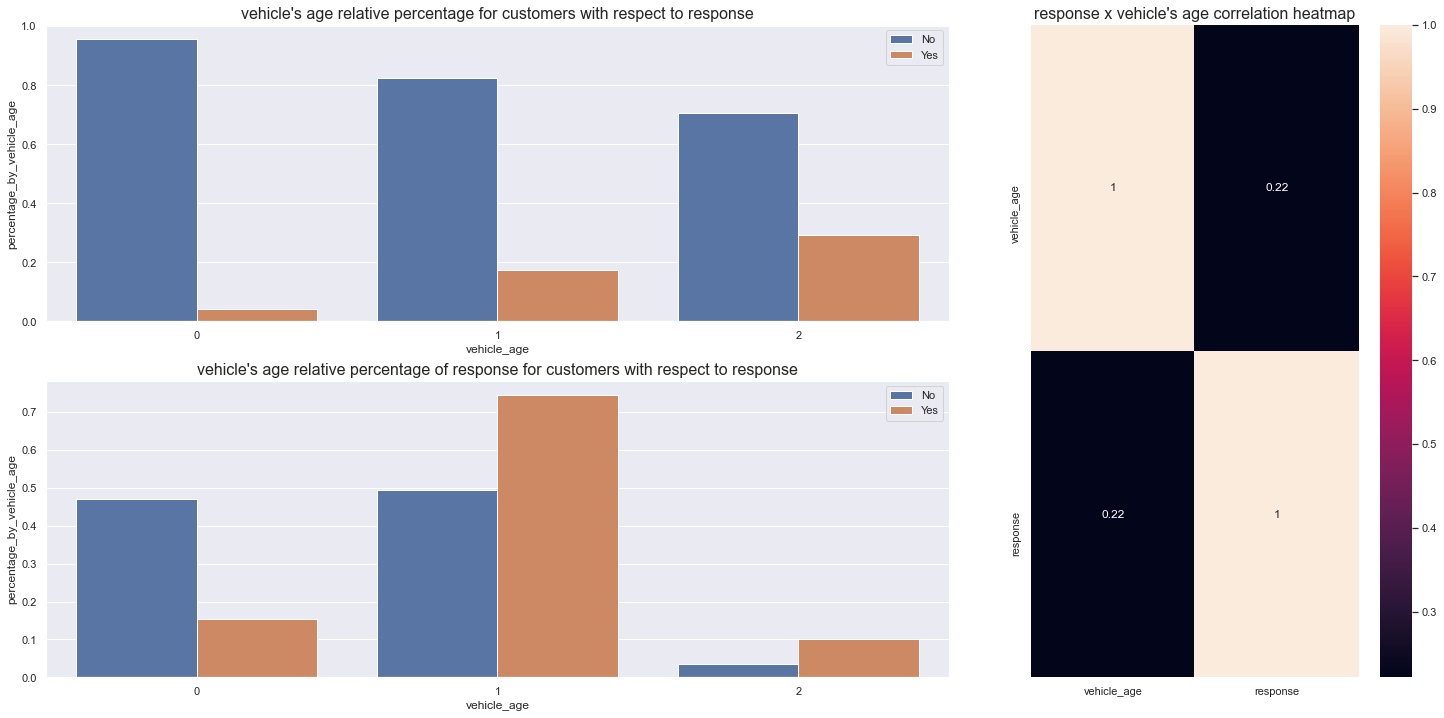

In [40]:
aux03 = df05_u[['vehicle_age', 'response']]

# Grid for ploting
plt.figure(figsize=(25, 12))
grid = GridSpec(2, 3)

# response x vehicle's age correlation heatmap
plt.subplot(grid[:,2])
sns.heatmap(aux03.corr(method='pearson'), annot=True).set_title("response x vehicle's age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# vehicle's age relative percentage for customers with respect to response
aux04 = pd.DataFrame()
vehicle_age_unique = aux03['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    aux04_0 = aux03[aux03['vehicle_age'] == age][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    aux04 = pd.concat([aux04, aux04_0])

## plot
plt.subplot(grid[0,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux04);
plt.legend();
plt.title("vehicle's age relative percentage for customers with respect to response", fontsize=16);



# Age stage relative percentage of response for customers with respect to response
aux03_0 = aux03[aux03['response'] == 'No'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03_1 = aux03[aux03['response'] == 'Yes'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03 = pd.concat([aux03_0, aux03_1], axis=0)

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux03);
plt.legend();
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

#### **H04** -  Longer customers who own vehicles that are more than 2 years old acquire insurance
---
> **Conclusion: FALSE**
>> - Longer customers who own vehicles that are more than 2 years old acquire insurance in the same frequency of the other customers

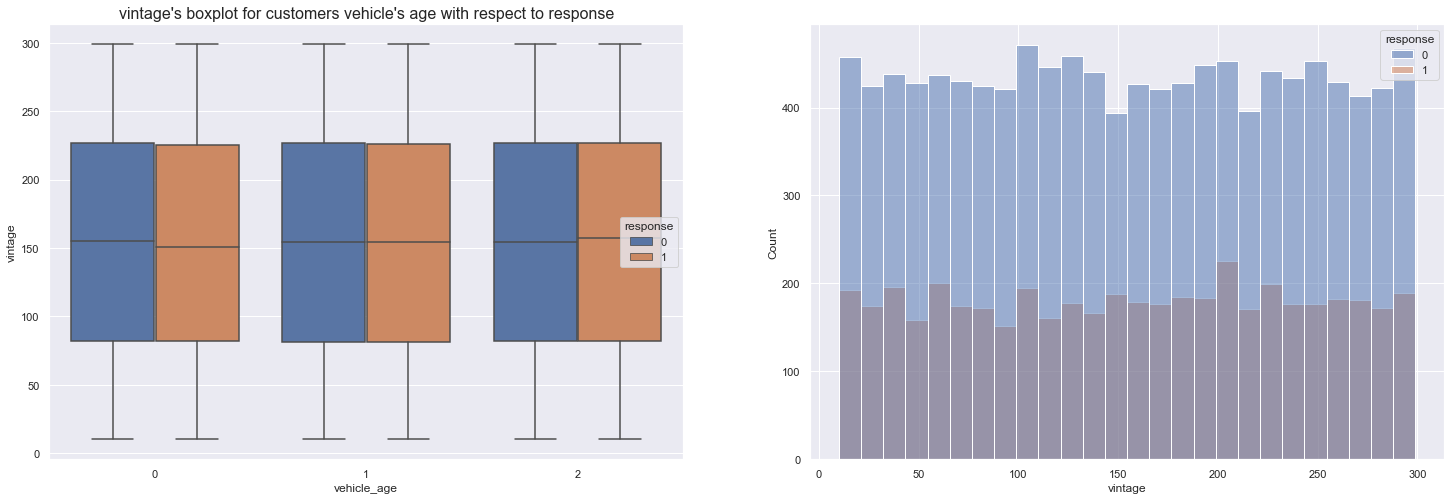

In [41]:
aux04 = df05_u[['vintage','vehicle_age', 'response']]

plt.figure(figsize=(25,8))
# age's boxplot for customers with respect to response
plt.subplot(1,2,1)
sns.boxplot(x="vehicle_age", y="vintage", hue="response", data=aux04).set_title("vintage's boxplot for customers vehicle's age with respect to response", fontsize=16);

plt.subplot(1,2,2)
sns.histplot(x='vintage', data=aux04[aux04['vehicle_age'] == 2], hue='response');

#### **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
---
> **Conclusion: **
>> - 

## 5.3 Multivariable analysis (Balanced Dataset)

In [42]:
num_attributes = df05.select_dtypes(include=['int64', 'float64'])
cat_attributes = df05.select_dtypes(exclude=['int64', 'float64'])

### 5.3.1 Numerical

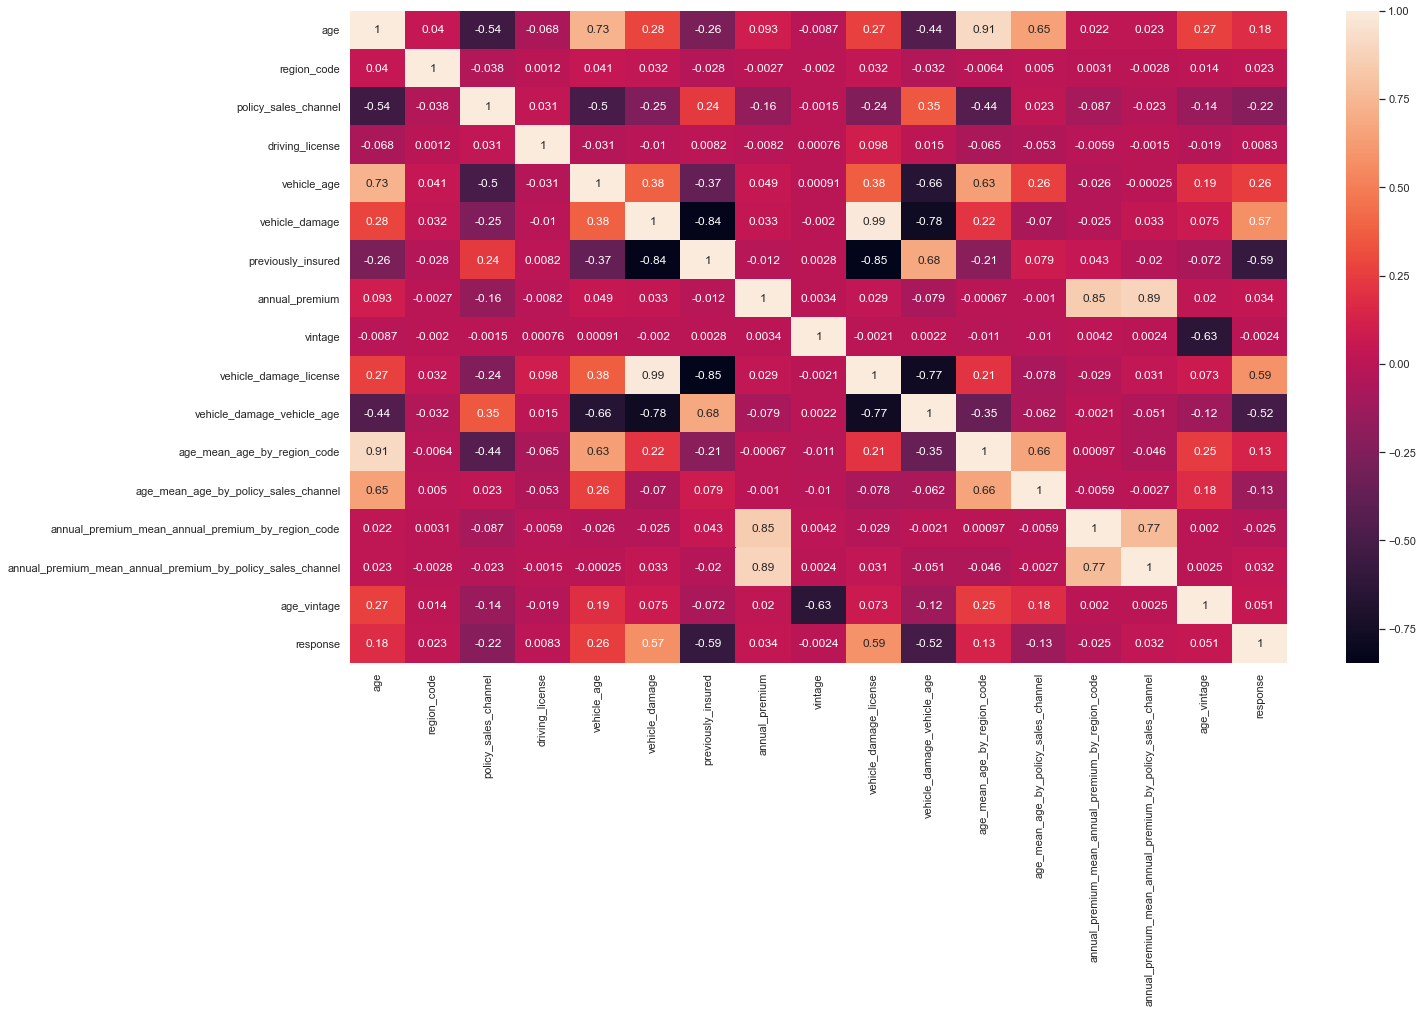

In [43]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 5.3.2 Categorical

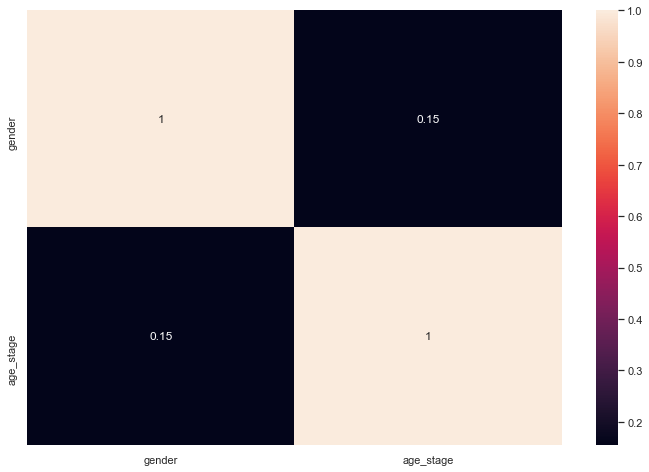

In [44]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(12,8))
sns.heatmap(d, annot=True);

# 6.0 Data Filtering (Attributes with High Correlation)

In [45]:
cols_drop = ['age', 'vehicle_damage', 'annual_premium']
df06 = df05.drop(cols_drop, axis=1)

#df06 = df05.copy() ### will be changed

# 7.0 Data Preparation

In [46]:
# Numerical
num_attributes = df06.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df06.select_dtypes(exclude=['int64', 'float64'])

## 7.1 Rescaling

## 7.2 Encoding

In [47]:
# Dummy variable
df07_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df07 = pd.concat([num_attributes, df07_dummy], axis=1)

## 7.3 Transformation

# 8.0 Feature Selection

In [48]:
df08 = df07.copy()

## 8.1 Boruta as Feature Selector

In [49]:
X = df08.drop(columns=['response'], axis=1)
y = df08['response'].copy()


# Training and Validation dataset for Boruta
X_train_n = X.to_numpy()
y_train_n = y.values.ravel()

# define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, verbose=1, n_estimators='auto', random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100


BorutaPy finished running.

Iteration: 	17 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	11


BorutaPy(estimator=RandomForestClassifier(n_estimators=48, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1B708B44C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1B708B44C40, verbose=1)

In [50]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['region_code',
 'policy_sales_channel',
 'previously_insured',
 'vintage',
 'vehicle_damage_license',
 'vehicle_damage_vehicle_age',
 'age_mean_age_by_region_code',
 'age_mean_age_by_policy_sales_channel',
 'annual_premium_mean_annual_premium_by_region_code',
 'annual_premium_mean_annual_premium_by_policy_sales_channel',
 'age_vintage']

## 8.? Split into Train and Validation

In [51]:
# cols_selected = ['age',
#                  'region_code',
#                  'policy_sales_channel',
#                  'vehicle_damage',
#                  'previously_insured',
#                  'annual_premium',
#                  'vintage',
#                  'vehicle_damage_license',
#                  'vehicle_damage_vehicle_age',
#                  'age_mean_age_by_region_code',
#                  'age_mean_age_by_policy_sales_channel',
#                  'annual_premium_mean_annual_premium_by_region_code',
#                  'annual_premium_mean_annual_premium_by_policy_sales_channel',
#                  'age_vintage']

cols_selected = ['region_code',
                 'policy_sales_channel',
                 'previously_insured',
                 'vintage',
                 'vehicle_damage_license',
                 'vehicle_damage_vehicle_age',
                 'age_mean_age_by_region_code',
                 'age_mean_age_by_policy_sales_channel',
                 'annual_premium_mean_annual_premium_by_region_code',
                 'annual_premium_mean_annual_premium_by_policy_sales_channel',
                 'age_vintage']


X = df08[cols_selected]
y = df08['response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

# 9.0 Machine Learning Model

## 9.1 Baseline model

### 9.1.1 Random Choices

In [52]:
response_list = y_train.drop_duplicates().sort_values().tolist()
response_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 9.1.2 Random Choices Performance

Accuracy: 0.5015862481992845
Balanced Accuracy: 0.500013913926795
Kappa Score: 2.782367814879727e-05
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     65327
           1       0.47      0.47      0.47     58235

    accuracy                           0.50    123562
   macro avg       0.50      0.50      0.50    123562
weighted avg       0.50      0.50      0.50    123562



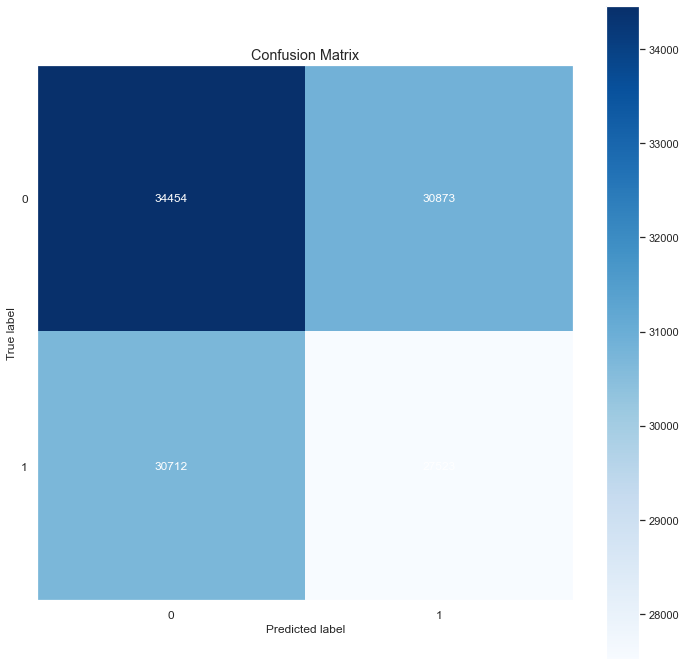

In [53]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 9.2 Machine Learning Model

### 9.2.1 Random Forest

In [54]:
# Model
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

yhat_rf = rf.predict(X_test)

#### 9.2.1.1 Performance

Accuracy: 0.9082970492546252
Balanced Accuracy: 0.9077511388904467
Kappa Score: 0.8158984972332377
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     65327
           1       0.91      0.90      0.90     58235

    accuracy                           0.91    123562
   macro avg       0.91      0.91      0.91    123562
weighted avg       0.91      0.91      0.91    123562



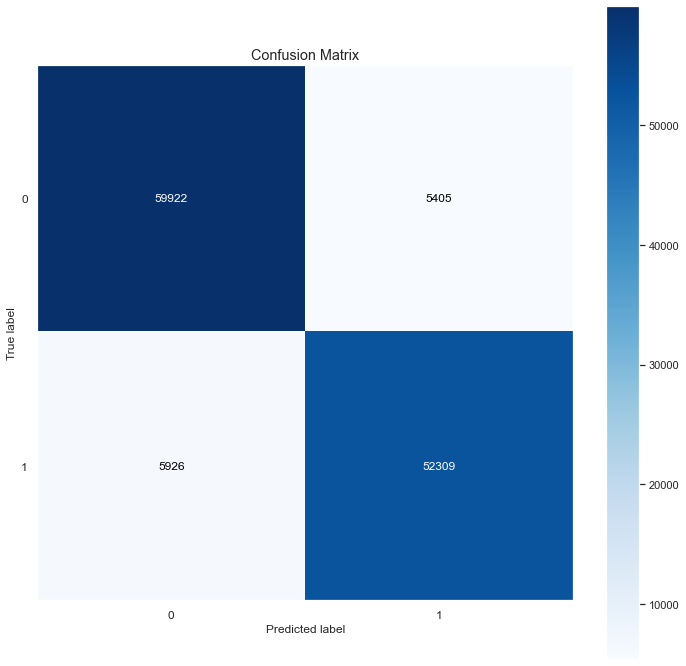

In [55]:
# Accuracy
acc_rf = accuracy_score(y_test, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_test, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_test, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_test, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_rf, normalize=False, figsize=(12, 12));

#### 9.2.1.2 Performance - Cross Validation

In [56]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
result_rf = cross_validation(X_train, y_train, 'Random Forest', model, num_folds=5, verbose=True)
result_rf

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Random Forest,0.9011 +/- 0.0005,0.8978 +/- 0.0013,0.8995 +/- 0.0006,0.8101 +/- 0.001,0.905 +/- 0.0005,0.9738 +/- 0.0003,0.974 +/- 0.0003


### 9.2.2 XGBoost Classifier

In [57]:
xgb = XGBClassifier(n_jobs=-1, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = xgb.predict(X_test)

[16:47:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### 9.2.2.1 Performance

Accuracy: 0.9050355287224228
Balanced Accuracy: 0.9032974031117003
Kappa Score: 0.8088989499106974
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     65327
           1       0.92      0.87      0.90     58235

    accuracy                           0.91    123562
   macro avg       0.91      0.90      0.90    123562
weighted avg       0.91      0.91      0.90    123562



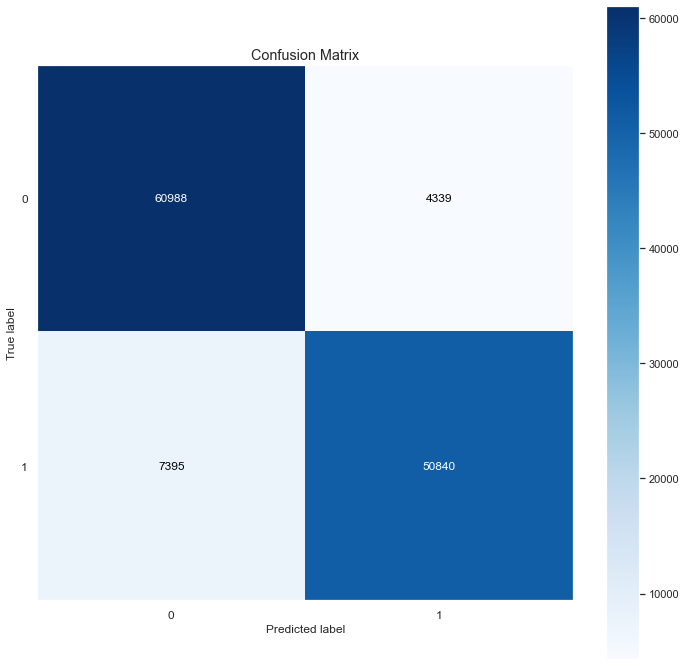

In [58]:
# Accuracy
acc_xgb = accuracy_score(y_test, yhat_xgb)
print('Accuracy: {}'.format(acc_xgb))

# Balanced Accuracy
balanced_acc_xgb = balanced_accuracy_score(y_test, yhat_xgb)
print('Balanced Accuracy: {}'.format(balanced_acc_xgb))

# Kappa Score
kappa_xgb = cohen_kappa_score(y_test, yhat_xgb)
print('Kappa Score: {}'.format(kappa_xgb))

# Classification Report
print(classification_report(y_test, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_xgb, normalize=False, figsize=(12, 12));

#### 9.2.2.2 Performance - Cross Validation

In [59]:
model = XGBClassifier(n_jobs=-1, random_state=42, verbosity=0)
result_xgb = cross_validation(X_train, y_train, 'XGBoost Classifier', model, num_folds=5, verbose=True)
result_xgb

Fold Number: 1/5
[16:47:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Number: 2/5
[16:48:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Number: 3/5
[16:48:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fold Number: 4/5
[1

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBoost Classifier,0.9213 +/- 0.0051,0.873 +/- 0.002,0.8965 +/- 0.0017,0.8087 +/- 0.0037,0.9032 +/- 0.0017,0.9747 +/- 0.0004,0.9738 +/- 0.0004


### 9.2.3 LightGBM Classifier

In [60]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)

# Prediction
yhat_lgbm = lgbm.predict(X_test)

#### 9.2.3.1 Performance

Accuracy: 0.8886146226186045
Balanced Accuracy: 0.8882758303019762
Kappa Score: 0.7765060624419678
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     65327
           1       0.88      0.88      0.88     58235

    accuracy                           0.89    123562
   macro avg       0.89      0.89      0.89    123562
weighted avg       0.89      0.89      0.89    123562



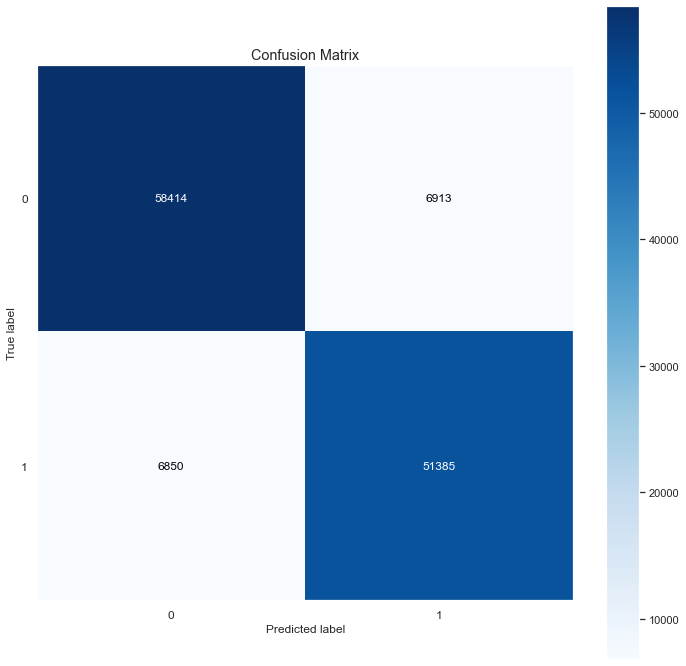

In [61]:
# Accuracy
acc_lgbm = accuracy_score(y_test, yhat_lgbm)
print('Accuracy: {}'.format(acc_lgbm))

# Balanced Accuracy
balanced_acc_lgbm = balanced_accuracy_score(y_test, yhat_lgbm)
print('Balanced Accuracy: {}'.format(balanced_acc_lgbm))

# Kappa Score
kappa_lgbm = cohen_kappa_score(y_test, yhat_lgbm)
print('Kappa Score: {}'.format(kappa_lgbm))

# Classification Report
print(classification_report(y_test, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_lgbm, normalize=False, figsize=(12, 12));

#### 9.2.3.2 Performance - Cross Validation

In [62]:
model = LGBMClassifier(n_jobs=-1, random_state=42)
result_lgbm = cross_validation(X_train, y_train, 'Lightgbm Classifier', model, num_folds=5, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Lightgbm Classifier,0.8802 +/- 0.002,0.8844 +/- 0.0019,0.8823 +/- 0.0003,0.7769 +/- 0.0008,0.8885 +/- 0.0004,0.9695 +/- 0.0004,0.9692 +/- 0.0003


### 9.2.4 Catboost Classifier

In [64]:
catb = CatBoostClassifier(random_state=42, verbose=False)
catb.fit(X_train, y_train)

# Prediction
yhat_catb = catb.predict(X_test)

#### 9.2.4.1 Performance

Accuracy: 0.9128939317913274
Balanced Accuracy: 0.909679702774677
Kappa Score: 0.824183059049018
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     65327
           1       0.96      0.85      0.90     58235

    accuracy                           0.91    123562
   macro avg       0.92      0.91      0.91    123562
weighted avg       0.92      0.91      0.91    123562



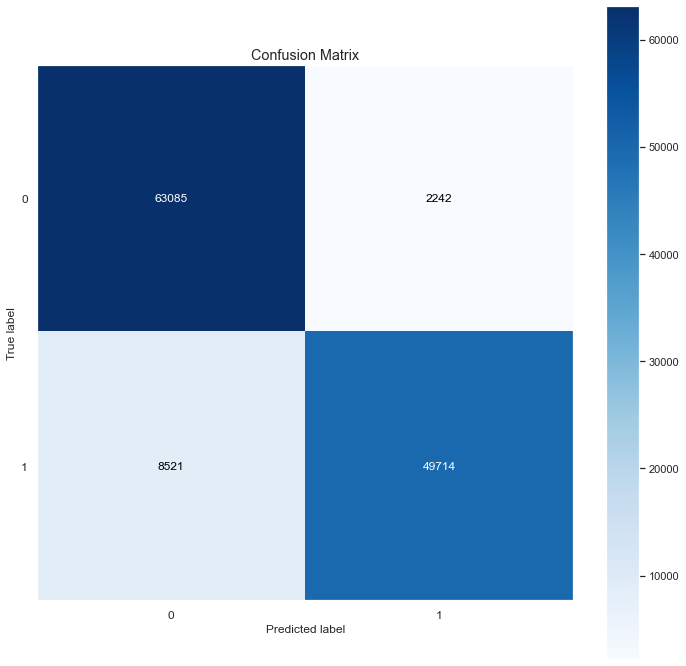

In [65]:
# Accuracy
acc_catb = accuracy_score(y_test, yhat_catb)
print('Accuracy: {}'.format(acc_catb))

# Balanced Accuracy
balanced_acc_catb = balanced_accuracy_score(y_test, yhat_catb)
print('Balanced Accuracy: {}'.format(balanced_acc_catb))

# Kappa Score
kappa_catb = cohen_kappa_score(y_test, yhat_catb)
print('Kappa Score: {}'.format(kappa_catb))

# Classification Report
print(classification_report(y_test, yhat_catb))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_catb, normalize=False, figsize=(12, 12));

#### 9.2.4.2 Performance - Cross Validation

In [66]:
model = CatBoostClassifier(random_state=42, verbose = False)
result_catb = cross_validation(X_train, y_train, 'CatBoost Classifier', model, num_folds=5, verbose=True)
result_catb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,CatBoost Classifier,0.9537 +/- 0.0028,0.8559 +/- 0.0022,0.9022 +/- 0.001,0.8235 +/- 0.0019,0.9094 +/- 0.0009,0.9763 +/- 0.0003,0.9753 +/- 0.0003


### 9.2.5 Logistic Regression

In [67]:
lr = LogisticRegression(max_iter=220, random_state=28)
lr.fit(X_train, y_train)

# Prediction
yhat_lr = lr.predict(X_test)

#### 9.2.5.1 Performance

Accuracy: 0.7763713763131059
Balanced Accuracy: 0.7860633513917132
Kappa Score: 0.5604347808160233
              precision    recall  f1-score   support

           0       0.94      0.62      0.74     65327
           1       0.69      0.95      0.80     58235

    accuracy                           0.78    123562
   macro avg       0.81      0.79      0.77    123562
weighted avg       0.82      0.78      0.77    123562



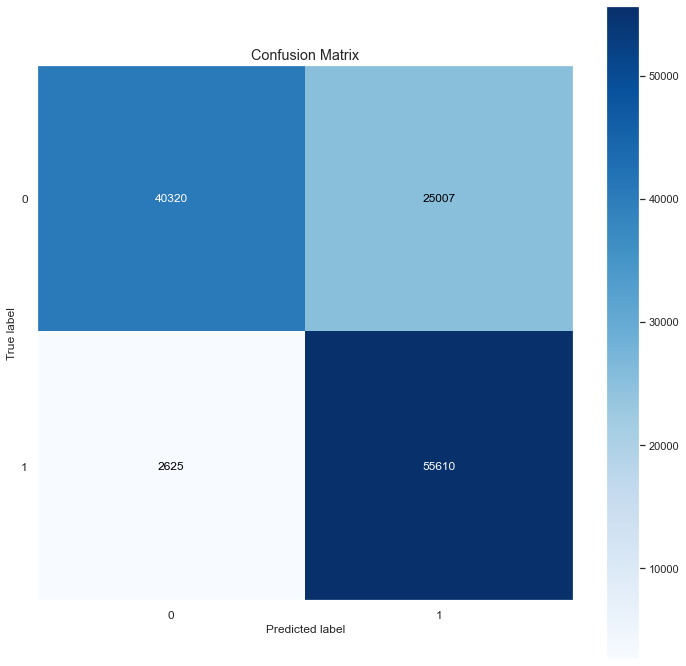

In [68]:
# Accuracy
acc_lr = accuracy_score(y_test, yhat_lr)
print('Accuracy: {}'.format(acc_lr))

# Balanced Accuracy
balanced_acc_lr = balanced_accuracy_score(y_test, yhat_lr)
print('Balanced Accuracy: {}'.format(balanced_acc_lr))

# Kappa Score
kappa_lr = cohen_kappa_score(y_test, yhat_lr)
print('Kappa Score: {}'.format(kappa_lr))

# Classification Report
print(classification_report(y_test, yhat_lr))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_lr, normalize=False, figsize=(12, 12));

#### 9.2.5.2 Performance - Cross Validation

In [69]:
model = LogisticRegression(max_iter=220, random_state=28)
result_lr = cross_validation(X_train, y_train, 'Logistic Regression', model, num_folds=5, verbose=True)
result_lr

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Logistic Regression,0.6885 +/- 0.0022,0.9551 +/- 0.0055,0.8002 +/- 0.0007,0.5582 +/- 0.0015,0.785 +/- 0.0007,0.7329 +/- 0.0019,0.8372 +/- 0.0009


### 9.2.6 KNN

In [70]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Prediction
yhat_knn = knn.predict(X_test)

#### 9.2.6.1 Performance

Accuracy: 0.8052394749194737
Balanced Accuracy: 0.8075901154100336
Kappa Score: 0.6115180117298684
              precision    recall  f1-score   support

           0       0.85      0.77      0.81     65327
           1       0.76      0.85      0.80     58235

    accuracy                           0.81    123562
   macro avg       0.81      0.81      0.81    123562
weighted avg       0.81      0.81      0.81    123562



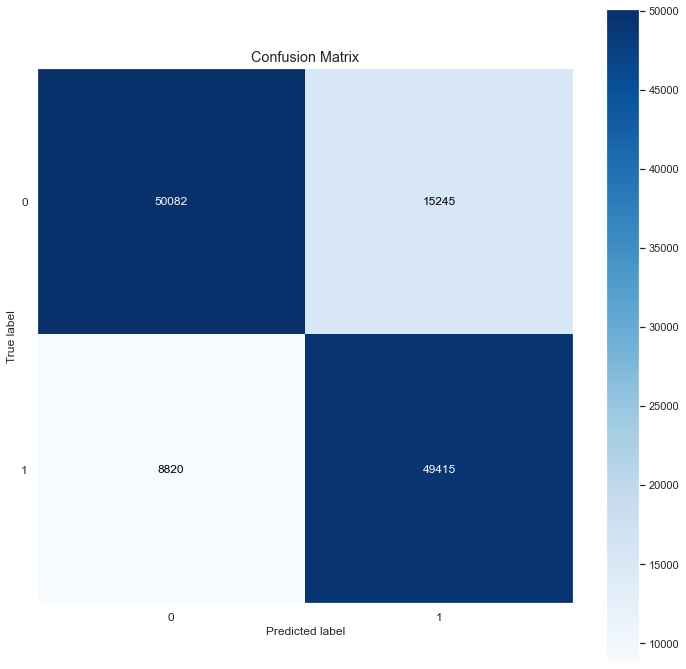

In [71]:
# Accuracy
acc_knn = accuracy_score(y_test, yhat_knn)
print('Accuracy: {}'.format(acc_knn))

# Balanced Accuracy
balanced_acc_knn = balanced_accuracy_score(y_test, yhat_knn)
print('Balanced Accuracy: {}'.format(balanced_acc_knn))

# Kappa Score
kappa_knn = cohen_kappa_score(y_test, yhat_knn)
print('Kappa Score: {}'.format(kappa_knn))

# Classification Report
print(classification_report(y_test, yhat_knn))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_knn, normalize=False, figsize=(12, 12));

#### 9.2.6.2 Performance - Cross Validation

In [72]:
model = KNeighborsClassifier()
result_knn = cross_validation(X_train, y_train, 'KNN', model, num_folds=5, verbose=True)
result_knn

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,KNN,0.7587 +/- 0.0007,0.8403 +/- 0.0008,0.7974 +/- 0.0004,0.5986 +/- 0.0009,0.8011 +/- 0.0004,0.7985 +/- 0.0004,0.8703 +/- 0.0004


### 9.2.7 Performance Comparison 

In [73]:
df_compare = pd.concat([result_rf, result_xgb, result_lgbm, result_catb, result_lr, result_knn], axis=0)
df_compare

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Random Forest,0.9011 +/- 0.0005,0.8978 +/- 0.0013,0.8995 +/- 0.0006,0.8101 +/- 0.001,0.905 +/- 0.0005,0.9738 +/- 0.0003,0.974 +/- 0.0003
0,XGBoost Classifier,0.9213 +/- 0.0051,0.873 +/- 0.002,0.8965 +/- 0.0017,0.8087 +/- 0.0037,0.9032 +/- 0.0017,0.9747 +/- 0.0004,0.9738 +/- 0.0004
0,Lightgbm Classifier,0.8802 +/- 0.002,0.8844 +/- 0.0019,0.8823 +/- 0.0003,0.7769 +/- 0.0008,0.8885 +/- 0.0004,0.9695 +/- 0.0004,0.9692 +/- 0.0003
0,CatBoost Classifier,0.9537 +/- 0.0028,0.8559 +/- 0.0022,0.9022 +/- 0.001,0.8235 +/- 0.0019,0.9094 +/- 0.0009,0.9763 +/- 0.0003,0.9753 +/- 0.0003
0,Logistic Regression,0.6885 +/- 0.0022,0.9551 +/- 0.0055,0.8002 +/- 0.0007,0.5582 +/- 0.0015,0.785 +/- 0.0007,0.7329 +/- 0.0019,0.8372 +/- 0.0009
0,KNN,0.7587 +/- 0.0007,0.8403 +/- 0.0008,0.7974 +/- 0.0004,0.5986 +/- 0.0009,0.8011 +/- 0.0004,0.7985 +/- 0.0004,0.8703 +/- 0.0004


# 10.0 Hyperparameter Fine Tuning

## 10.1 XGBoost Classifier

In [77]:
df_results_xgb = pd.DataFrame()
df_train_tuning = pd.concat([X, y], axis=1)

def tune_xgb(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]
    
    dict_params = {'lr':                   lr,
                   'max_depth':            max_depth,
                   'min_child_weight':     min_child_weight,
                   'subsample':            subsample,
                   'colsample_bytree':    colsample_bytree,
                   'n_estimators':         n_estimators,
                   'gamma':                gamma}
    
    
    model_name = 'XGBoost Classifier'
    kfold = 5
    
    param_list =[]
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    
    
    X_training = df_train_tuning.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kFold_training = training.drop(['response'], axis=1)
        y_kFold_training = training['response']

        # Validation
        X_kFold_validation = validation.drop(['response'], axis=1)
        y_kFold_validation = validation['response']
        
        
        #Model
        model = XGBClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_weight=params[2],
                                        subsample=params[3], colsample_bytree=params[4], n_estimators=params[5], gamma=params[6],
                                        bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)
    
    
        
        model.fit(X_kFold_training, y_kFold_training)
    
           # Prediction
        yhat = model.predict(X_kFold_validation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(X_kFold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kFold_validation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'])
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),2).astype(str)],
                    'Balanced Accuracy CV': [np.round(np.mean(balanced_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),2).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_results_xgb
    df_results_xgb = pd.concat([df_metrics, df_results_xgb], axis=0)
    
    return -np.mean(precision_acc_list)



space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma



result = forest_minimize(tune_xgb, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[17:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not 

[17:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[17:33:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[17:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:46:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

[17:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:54:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.00254165132488824, 6, 3, 0.11162953998372366, 0.747558502228283, 449, 0.09487158265955661]
[17:54:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bagging_freq, colsample_by_tree, num_leaves } might not be 

KeyboardInterrupt: 

In [ ]:
result.x
# [0.06625204097578263, 9, 7, 0.4886035071955117, 0.8899327352662949, 974, 0.07446537752748579] # balanced_acc_list

In [ ]:
df_results_xgb.head(20)

## 10.2 Lightgbm Classifier

In [95]:
df_results_lgbm = pd.DataFrame()
df_train_tuning = pd.concat([X, y], axis=1)

def tune_lgbm(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_samples = params[2]
    subsample         = params[3]
    colsample_bytree = params[4]
    n_estimators      = params[5]

    
    dict_params = {'lr':                   lr,
                   'max_depth':            max_depth,
                   'min_child_samples':    min_child_samples,
                   'subsample':            subsample,
                   'colsample_bytree':    colsample_bytree,
                   'n_estimators':         n_estimators}
    
    
    model_name = 'Lightgbm Classifier'
    kfold = 5
    
    param_list =[]
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    
    
    X_training = df_train_tuning.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kFold_training = training.drop(['response'], axis=1)
        y_kFold_training = training['response']

        # Validation
        X_kFold_validation = validation.drop(['response'], axis=1)
        y_kFold_validation = validation['response']
        
        
        #Model
        model = LGBMClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_samples=params[2],
                                        subsample=params[3], colsample_bytree=params[4], n_estimators=params[5],
                                        random_state=0, n_jobs=-1)
    
    
        
        model.fit(X_kFold_training, y_kFold_training)
    
           # Prediction
        yhat = model.predict(X_kFold_validation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(X_kFold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kFold_validation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'])
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),2).astype(str)],
                    'Balanced Accuracy CV': [np.round(np.mean(balanced_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),2).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_results_lgbm
    df_results_lgbm = pd.concat([df_metrics, df_results_lgbm], axis=0)
    
    return -np.mean(balanced_acc_list)




space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors



result = forest_minimize(tune_lgbm, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 14.5410
Function value obtained: -0.8464
Current minimum: -0.8464
Iteration No: 2 started. Evaluating function at random point.
[0.0010385556240017917, 2, 10, 0.14183771058242609, 0.7437489153990157, 249]


KeyboardInterrupt: 

In [169]:
result.x
# [0.035432749192096984, 10, 13, 0.1530283556568924, 0.6623654100211082, 732]

[0.035432749192096984, 10, 13, 0.1530283556568924, 0.6623654100211082, 732]

In [170]:
df_results_lgbm.head(20)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy CV,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,0.72 +/- 0.0,0.98 +/- 0.0,0.83 +/- 0.0,0.6 +/- 0.0,0.8 +/- 0.0,0.82 +/- 0.0,0.88 +/- 0.0,"[{'lr': 0.003859705757436628, 'max_depth': 2, ..."
0,Lightgbm Classifier,0.82 +/- 0.0,0.93 +/- 0.0,0.87 +/- 0.0,0.73 +/- 0.0,0.87 +/- 0.0,0.95 +/- 0.0,0.96 +/- 0.0,"[{'lr': 0.0066328042405379645, 'max_depth': 8,..."
0,Lightgbm Classifier,0.87 +/- 0.01,0.91 +/- 0.0,0.89 +/- 0.0,0.78 +/- 0.0,0.89 +/- 0.0,0.97 +/- 0.0,0.97 +/- 0.0,"[{'lr': 0.061810855225848234, 'max_depth': 9, ..."
0,Lightgbm Classifier,0.78 +/- 0.0,0.95 +/- 0.0,0.86 +/- 0.0,0.69 +/- 0.0,0.84 +/- 0.0,0.92 +/- 0.0,0.93 +/- 0.0,"[{'lr': 0.015665337619230394, 'max_depth': 4, ..."
0,Lightgbm Classifier,0.75 +/- 0.0,0.96 +/- 0.0,0.84 +/- 0.0,0.65 +/- 0.01,0.82 +/- 0.0,0.86 +/- 0.0,0.9 +/- 0.0,"[{'lr': 0.0022449729419144397, 'max_depth': 4,..."
0,Lightgbm Classifier,0.71 +/- 0.0,0.98 +/- 0.0,0.82 +/- 0.0,0.58 +/- 0.0,0.79 +/- 0.0,0.75 +/- 0.0,0.83 +/- 0.0,"[{'lr': 0.0021108116772730425, 'max_depth': 2,..."
0,Lightgbm Classifier,0.91 +/- 0.01,0.9 +/- 0.0,0.9 +/- 0.0,0.81 +/- 0.01,0.9 +/- 0.0,0.98 +/- 0.0,0.98 +/- 0.0,"[{'lr': 0.02151017641719756, 'max_depth': 8, '..."
0,Lightgbm Classifier,0.81 +/- 0.0,0.94 +/- 0.0,0.87 +/- 0.0,0.71 +/- 0.0,0.86 +/- 0.0,0.95 +/- 0.0,0.95 +/- 0.0,"[{'lr': 0.004203255075983761, 'max_depth': 7, ..."
0,Lightgbm Classifier,0.74 +/- 0.0,0.96 +/- 0.0,0.83 +/- 0.0,0.62 +/- 0.0,0.81 +/- 0.0,0.84 +/- 0.01,0.88 +/- 0.0,"[{'lr': 0.0012116790683302117, 'max_depth': 3,..."
0,Lightgbm Classifier,0.8 +/- 0.0,0.93 +/- 0.0,0.86 +/- 0.0,0.7 +/- 0.0,0.85 +/- 0.0,0.93 +/- 0.0,0.94 +/- 0.0,"[{'lr': 0.01909842850485622, 'max_depth': 3, '..."


## 10.3 CatBoost Classifier

In [175]:
df_results_catb = pd.DataFrame()
df_train_tuning = pd.concat([X, y], axis=1)

def tune_catb(params):
    print(params)
    iterations          = params[0]
    depth               = params[1]
    lr                  = params[2]
    random_strength     = params[3]
    bagging_temperature = params[4]
    border_count        = params[5]
    scale_pos_weight    = params[6]

    
    dict_params = {'iterations'              : iterations,
                   'depth'                   : depth,
                   'lr'                      : lr,
                   'random_strength'         : random_strength,
                   'bagging_temperature'     : bagging_temperature,
                   'border_count'            : border_count,
                   'scale_pos_weight'        : scale_pos_weight}
    
    
    model_name = 'CatBoost Classifier'
    kfold = 5
    
    param_list =[]
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    
    
    X_training = df_train_tuning.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kFold_training = training.drop(['response'], axis=1)
        y_kFold_training = training['response']

        # Validation
        X_kFold_validation = validation.drop(['response'], axis=1)
        y_kFold_validation = validation['response']
        
        
        #Model
        model = CatBoostClassifier(iterations=params[0], depth=params[1], learning_rate=params[2], random_strength=params[3], bagging_temperature=params[4], 
                                   border_count=params[5], scale_pos_weight=params[6],
                                   thread_count=2, loss_function='Logloss', random_state=0, verbose = False)

        
        model.fit(X_kFold_training, y_kFold_training)
    
           # Prediction
        yhat = model.predict(X_kFold_validation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(X_kFold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kFold_validation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'])
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),2).astype(str)],
                    'Balanced Accuracy CV': [np.round(np.mean(balanced_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),2).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_results_catb
    df_results_catb = pd.concat([df_metrics, df_results_catb], axis=0)
    
    return -np.mean(balanced_acc_list)


space = [(100, 1000), # iterations
         (1, 10), # depth
         (1e-3, 1e-1, 'log-uniform'), # lr
         (1e-9, 10), # random_strength
         (0.0, 1.0), # bagging_temperature
         (1, 255), # border_count
         (0.01, 1.0)] # scale_pos_weight



result = forest_minimize(tune_catb, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[958, 5, 0.006232523056719093, 7.18372733005025, 0.4396955275715161, 216, 0.6339359146848248]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 260.1653
Function value obtained: -0.8383
Current minimum: -0.8383
Iteration No: 2 started. Evaluating function at random point.
[814, 9, 0.053887464791860025, 0.966712743876235, 0.7302620162094902, 150, 0.16923788572159984]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 322.2560
Function value obtained: -0.8929
Current minimum: -0.8929
Iteration No: 3 started. Evaluating function at random point.
[110, 5, 0.04442768967775552, 1.0966576629920766, 0.8612710635600836, 174, 0.6125275426948037]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 21.2920
Function value obtained: -0.8363
Current minimum: -0.8929
Iteration No: 4 started. Evaluating function at random point.
[975, 9, 0.02261102434101718, 2.0590845257629113, 0.68974918405

In [176]:
result.x
# [975, 9, 0.02261102434101718, 2.0590845257629113, 0.6897491840581811, 217, 0.676814333008794]

[975,
 9,
 0.02261102434101718,
 2.0590845257629113,
 0.6897491840581811,
 217,
 0.676814333008794]

In [177]:
df_results_catb.head(20)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy CV,Average Precision Score CV,ROC AUC CV,Params
0,CatBoost Classifier,0.83 +/- 0.01,0.79 +/- 0.01,0.81 +/- 0.0,0.63 +/- 0.0,0.82 +/- 0.0,0.91 +/- 0.01,0.92 +/- 0.0,"[{'iterations': 198, 'depth': 9, 'lr': 0.01207..."
0,CatBoost Classifier,0.75 +/- 0.0,0.93 +/- 0.0,0.83 +/- 0.0,0.63 +/- 0.0,0.81 +/- 0.0,0.85 +/- 0.0,0.89 +/- 0.0,"[{'iterations': 193, 'depth': 3, 'lr': 0.00777..."
0,CatBoost Classifier,0.94 +/- 0.0,0.67 +/- 0.01,0.78 +/- 0.01,0.63 +/- 0.01,0.82 +/- 0.0,0.95 +/- 0.0,0.95 +/- 0.0,"[{'iterations': 777, 'depth': 5, 'lr': 0.00977..."
0,CatBoost Classifier,0.99 +/- 0.0,0.76 +/- 0.0,0.86 +/- 0.0,0.75 +/- 0.0,0.88 +/- 0.0,0.97 +/- 0.0,0.97 +/- 0.0,"[{'iterations': 912, 'depth': 6, 'lr': 0.02428..."
0,CatBoost Classifier,0.8 +/- 0.0,0.76 +/- 0.0,0.78 +/- 0.0,0.57 +/- 0.0,0.78 +/- 0.0,0.88 +/- 0.0,0.89 +/- 0.0,"[{'iterations': 303, 'depth': 5, 'lr': 0.00116..."
0,CatBoost Classifier,0.88 +/- 0.01,0.88 +/- 0.0,0.88 +/- 0.0,0.76 +/- 0.01,0.88 +/- 0.0,0.97 +/- 0.0,0.97 +/- 0.0,"[{'iterations': 424, 'depth': 8, 'lr': 0.04383..."
0,CatBoost Classifier,0.99 +/- 0.0,0.48 +/- 0.0,0.65 +/- 0.0,0.48 +/- 0.0,0.74 +/- 0.0,0.95 +/- 0.0,0.95 +/- 0.0,"[{'iterations': 464, 'depth': 2, 'lr': 0.05173..."
0,CatBoost Classifier,0.85 +/- 0.01,0.71 +/- 0.0,0.78 +/- 0.0,0.59 +/- 0.01,0.79 +/- 0.0,0.91 +/- 0.0,0.91 +/- 0.0,"[{'iterations': 665, 'depth': 9, 'lr': 0.00156..."
0,CatBoost Classifier,0.85 +/- 0.02,0.56 +/- 0.06,0.68 +/- 0.04,0.47 +/- 0.04,0.73 +/- 0.02,0.87 +/- 0.0,0.89 +/- 0.0,"[{'iterations': 208, 'depth': 2, 'lr': 0.00420..."
0,CatBoost Classifier,0.84 +/- 0.0,0.86 +/- 0.0,0.85 +/- 0.0,0.69 +/- 0.01,0.85 +/- 0.0,0.94 +/- 0.0,0.94 +/- 0.0,"[{'iterations': 528, 'depth': 6, 'lr': 0.00912..."


## 10.4 Random Forest Classifier

In [52]:
df_results_rf = pd.DataFrame()
df_train_tuning = pd.concat([X, y], axis=1)

def tune_rf(params):
    print(params)
    max_depth = params[0]
    min_samples_leaf = params[1]
    n_estimators = params[2]
    
    dict_params = {'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf,
                   'n_estimators': n_estimators}
    
    
    model_name = 'Random Forest Classifier'
    kfold = 5
    
    param_list =[]
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    
    
    X_training = df_train_tuning.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kFold_training = training.drop(['response'], axis=1)
        y_kFold_training = training['response']

        # Validation
        X_kFold_validation = validation.drop(['response'], axis=1)
        y_kFold_validation = validation['response']
        
        
        #Model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0,
                                           class_weight='balanced', n_jobs=-1)
    
    
        
        model.fit(X_kFold_training, y_kFold_training)
    
        # Prediction
        yhat = model.predict(X_kFold_validation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(X_kFold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kFold_validation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'])
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),2).astype(str)],
                    'Balanced Accuracy CV': [np.round(np.mean(balanced_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),2).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_results_rf
    df_results_rf = pd.concat([df_metrics, df_results_rf], axis=0)
    
    return -np.mean(balanced_acc_list)




space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors



result = forest_minimize(tune_rf, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 171.8211
Function value obtained: -0.8172
Current minimum: -0.8172
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 23.9997
Function value obtained: -0.7806
Current minimum: -0.8172
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 92.7297
Function value obtained: -0.8434
Current minimum: -0.8434
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 85.4063
Function value obtained: -0.7807
Current minimum: -0.8434
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 29.0678
Function value 

In [53]:
result.x
# [10, 1, 491]

[10, 1, 491]

In [54]:
df_results_rf.head(20)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy CV,Average Precision Score CV,ROC AUC CV,Params
0,Random Forest Classifier,0.77 +/- 0.0,0.95 +/- 0.0,0.85 +/- 0.0,0.66 +/- 0.0,0.83 +/- 0.0,0.9 +/- 0.0,0.91 +/- 0.0,"[{'max_depth': 7, 'min_samples_leaf': 7, 'n_es..."
0,Random Forest Classifier,0.79 +/- 0.0,0.95 +/- 0.0,0.86 +/- 0.0,0.69 +/- 0.0,0.85 +/- 0.0,0.92 +/- 0.0,0.93 +/- 0.0,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."
0,Random Forest Classifier,0.75 +/- 0.0,0.95 +/- 0.0,0.84 +/- 0.0,0.63 +/- 0.0,0.82 +/- 0.0,0.88 +/- 0.0,0.9 +/- 0.0,"[{'max_depth': 5, 'min_samples_leaf': 14, 'n_e..."
0,Random Forest Classifier,0.74 +/- 0.0,0.95 +/- 0.0,0.83 +/- 0.0,0.63 +/- 0.0,0.81 +/- 0.0,0.86 +/- 0.0,0.89 +/- 0.0,"[{'max_depth': 4, 'min_samples_leaf': 15, 'n_e..."
0,Random Forest Classifier,0.79 +/- 0.0,0.95 +/- 0.0,0.86 +/- 0.0,0.69 +/- 0.0,0.85 +/- 0.0,0.92 +/- 0.0,0.93 +/- 0.0,"[{'max_depth': 10, 'min_samples_leaf': 5, 'n_e..."
0,Random Forest Classifier,0.79 +/- 0.0,0.94 +/- 0.0,0.86 +/- 0.0,0.69 +/- 0.0,0.85 +/- 0.0,0.92 +/- 0.0,0.93 +/- 0.0,"[{'max_depth': 10, 'min_samples_leaf': 19, 'n_..."
0,Random Forest Classifier,0.7 +/- 0.0,0.98 +/- 0.0,0.81 +/- 0.0,0.56 +/- 0.0,0.78 +/- 0.0,0.77 +/- 0.0,0.84 +/- 0.0,"[{'max_depth': 1, 'min_samples_leaf': 13, 'n_e..."
0,Random Forest Classifier,0.76 +/- 0.0,0.94 +/- 0.0,0.84 +/- 0.0,0.65 +/- 0.0,0.82 +/- 0.0,0.89 +/- 0.0,0.91 +/- 0.0,"[{'max_depth': 6, 'min_samples_leaf': 12, 'n_e..."
0,Random Forest Classifier,0.74 +/- 0.0,0.96 +/- 0.0,0.83 +/- 0.0,0.62 +/- 0.0,0.81 +/- 0.0,0.84 +/- 0.0,0.88 +/- 0.0,"[{'max_depth': 3, 'min_samples_leaf': 5, 'n_es..."
0,Random Forest Classifier,0.79 +/- 0.0,0.95 +/- 0.0,0.86 +/- 0.0,0.7 +/- 0.0,0.85 +/- 0.0,0.92 +/- 0.0,0.93 +/- 0.0,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."


# SHAP

In [ ]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values[:,:], X_train)

In [ ]:
shap.dependence_plot("region_code", shap_values, X_train, interaction_index=None)

In [ ]:
shap.dependence_plot("region_code", shap_values, X_train, interaction_index='vintage')

In [ ]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

In [82]:
xgb = XGBClassifier(n_jobs=-1, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = xgb.predict(X_test)

In [81]:
print("Training " + type(xgb).__name__ + "...")

Training XGBClassifier...
